<a href="https://colab.research.google.com/github/comaraDOTcom/machine-vision/blob/main/deep-learning/Etivity_assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Student details
Name: Conor O'Mara  
Student Number: 20151845

# Etivity Assignment 3: Object co-localisation
In this assignment we will use the [Deep Descriptor Transforming (DDT) Technique](https://arxiv.org/pdf/1707.06397.pdf) to perform object co-localisation. The object localisation task involves finding the location of the primary object in an image (same object as image classification result). In the object co-localisation task the goal is to find the objects in images all of the same class. As detailed in the DDT paper, this can be achieved in a unsuperivsed manner from the feature map outputs of a pre-trained network. (In the image: Green bounding box is ground truth, Red boxes are obtained from DDT)
![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/etivity3_assignment_img.JPG?raw=true)

This technique (like Class activiation mapping) demonstrates that spatial information is contained with Deep Neural Networks trained for classification. This information can be used to generate region proposals or for direct object detection. The  unsupervised technique proposed in this paper is useful as it avoids the necessity of having bounding box information to adapt the pre-trained network for localisation.

In this Assignment you will perform object co-localisation using the stanford dogs dataset and the pre-trained VGG-16 network. This Jupyter notebook loads the stanford dogs dataset and also sets up the pre-trained Keras VGG-16 model so that the features of the convolutional layer are output. (Output layers of the model can be changed if required).  

In section 4. of the notebook you will implement the DDT algorithm and demonstrate prediction of bounding boxes. (Ground truth bounding boxes are available for comparison with your prediction).

You may find the following information useful:

*   [Sklearn PCA Functions](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
* [Tensorflow resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) (interpolation function)
*   OpenCV Connected Components (PyImageSearch example [link text](https://www.pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/)) Note that if you want to use OpenCv on the output tensors then it will be necessary to need to convert the tensor to a numpy array uisng `.numpy()` and also ensure that have the numpy array in uint8 format `.astype(np.uint8)`
* If you wish to display any of the images from the dataset, please note that they have been processed prior to input to the network. In order to unprocess the image for display, please use: `helper.unprocess_image(img)`

In order to obtain an exemplary grade you will be required to implement the DDT+ algorithm. This will involve use of additional feature map information to refine the position of the bounding box compared to the basic approach (as shown in the images below). You will implement the DDT+ algorithm on the [Pascale Visual Object Classes Challenge](https://homepages.inf.ed.ac.uk/ckiw/postscript/ijcv_voc09.pdf) "Sheep" class. This is more challenging than the stanford dogs dataset, as objects appear at different scales. Note that the DDT+ approach also causes failures in bounding boxes for many images, you can comment on this in your notebook. 

Image: DDT+ Performance (Cyan: DDT+ bouding boxes, Red DDT: bounding boxes, Green: Ground Truth) 
![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/etivity3b_assignment.JPG?raw=true)

* Note: Completed list of VoC Classes 0-airplane, 1-bicycle, 2-bird, 3-boat, 4-bottle, 5-bus, 6-car, 7-cat, 8-chair, 9-cow, 10-dining table, 11-dog, 12-horse, 13-motorbike, 14-person, 15-potted plant, 16-sheep, 17-sofa, 18-train, 19-TV/monitor.










# 1. HouseKeeping
 Clone Repository & Import Packages 

In [1]:
# Clone repository to gain access to helper.py
!git clone https://github.com/tonyscan6003/CE6003.git

Cloning into 'CE6003'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 386 (delta 110), reused 0 (delta 0), pack-reused 142
Receiving objects: 100% (386/386), 5.99 MiB | 24.03 MiB/s, done.
Resolving deltas: 100% (169/169), done.


In [2]:
import tensorflow as tf
import CE6003.python.helper as helper
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow_datasets as tfds
from sklearn.decomposition import PCA

In [3]:
# Global Variables
HW_trg = helper.myList[0]      # Target Input Image size
batch_size = helper.myList[1]  # Batch Size
data_set = ["stanford_dogs"]   # Dataset (and add class integer to list for VoC))

## 2A. Import Dataset

In [4]:
if data_set == ["stanford_dogs"]:
   src_train_dataset,info = tfds.load(data_set[0],split='train',with_info=True)
   src_test_dataset,info = tfds.load(data_set[0],split='test',with_info=True)
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRTA8B9/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRTA8B9/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }

## 2B. Create Train and Test dataset splits 

Note that the images from the stanford dog and many other datasets are not uniform in size. The `gen_datasets` function calls other routines from helper.py that scale the images from the dataset so the longest side fits into the 224 x 224 input window size of VGG16. The aspect ratio of the image is preserved, so the shorter side of the image is padded with zeros. The shorter side is randomly translated providing some data augmentation. (Augmentation is not important for this task). The routines also scale ground truth bounding boxes to match the scale and translation of the image.

In [5]:
train_dataset, test_dataset =helper.gen_datasets(data_set,src_train_dataset,src_test_dataset)

Display Some Training Images with Ground truth Bounding Box

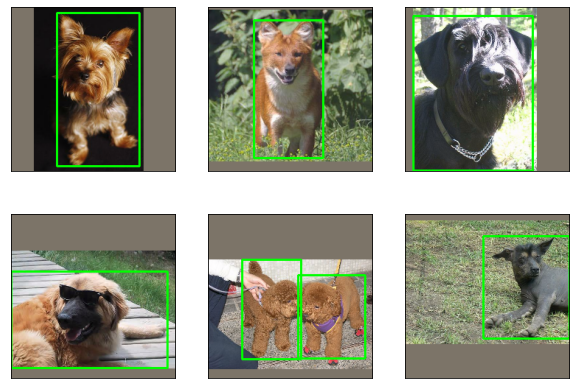

In [6]:
helper.display_dataset_img(train_dataset)

## 3A. Import and Setup VGG model
For this assignment we will use the convolutional layers of the VGG-16 module. The sturucture & layer names of the VGG-16 can be viewed on [Netscope](https://ethereon.github.io/netscope/#/preset/vgg-16). The layer_names variable allows selection of the output layer(s) of the model.


In [7]:
# Select Output Layers
layer_names = ['block5_conv3']

# Load base model
def base_vgg_model():
   IMG_SHAPE = (HW_trg, HW_trg, 3)
   base_vgg_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')
   
   op_list=[base_vgg_model.get_layer(layer).output for layer in layer_names]
   base_model= tf.keras.Model(inputs=base_vgg_model.input, outputs=op_list)

   return base_model

In [8]:
base_model = base_vgg_model()
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

## 3B. Extract output features maps from Model.

The function `gen_batch_features` in the code cell below applies `n_img` images from the test or training set to the model. The function returns batch tensors of the image, ground truth boxes and features. The 0 dimension of the tensor corresponds to each image/feature pair.

In [9]:
def gen_batch_features(train_dataset,n_img):

    cntr = 0
    for img, boxes, obj_cen, labels in train_dataset.take(n_img):
       img = img.to_tensor(shape=[batch_size, HW_trg, HW_trg, 3])
       A = base_model(img)

       # Append output features 
       if cntr >0:
          op_features = tf.concat([op_features,A],axis=0)
          img_batch = tf.concat([img_batch,img],axis=0)
          boxes_batch = tf.concat([boxes_batch,boxes],axis=0)
       else:   
          op_features= A
          img_batch = img
          boxes_batch = boxes
       cntr +=1  
     
    return img_batch,boxes_batch,op_features   

In [10]:
n_img=100 # Default value.
img_batch,batch_boxes,op_features=gen_batch_features(train_dataset,n_img)
img_batch_test,batch_boxes_test,op_features_test=gen_batch_features(test_dataset,n_img)
print(np.shape(op_features))
print(np.shape(batch_boxes_test))
print(np.shape(img_batch_test))

(100, 14, 14, 512)
(100, None, 4)
(100, 224, 224, 3)


## 4. DDT Algorithm

In the code cells below add your implementation of the DDT Algorithm for object co-localisation.

### DDT Algorithm (From [Wei 2017 paper](https://arxiv.org/pdf/1707.06397.pdf))

***Require:*** A set of N images containing the common object,
and a pre-trained CNN model F;  
1: Feed these images with their original resolutions into F;  
2: Collect the corresponding convolutional descriptors. 
X1, . . . , XN from the last convolutional layer of F;  
3: Calculate the mean vector x¯ of all the descriptors using
Eq. 1;  
4: Compute the covariance matrix Cov(x) of these deep
descriptors based on Eq. 2;  
5: Compute the eigenvectors ξ1, . . . , ξd of Cov(x);  
6: Select ξ1 with the largest eigenvalue as the main transforming direction;  
7: repeat.  
8: Calculate the indicator matrix P. 
1 for image I based
on Eq. 3 and Eq. 4;  
9: Resize P1 into its image’s resolution by nearest interpolation;  
10: Collect the largest connected component Pˆ1
c of these
positive regions of the resized P
1 by Algo. 1;  
11: Obtain the minimum rectangle bounding box covering
Pˆ1
c as the prediction;  
12: until All the N images are done;  
13: return The minimum rectangle bounding boxes.


In [11]:
def calculate_mean_vector(descriptors):
  """
  Function to calculate the mean of the descriptors assuming all images have the same
  number of deep desriptors h x w and there are N images. (Uses equation 1 from paper)
  """  
  return np.full(descriptors.shape, np.mean(descriptors))

def compute_principal_component_vector(descriptors):
  """
  Steps 4-6 can be calculated using the PCA library in SKlearn. To get the largest 
  eigenvalue, the n=1 component of the library is tranformed.
  """  
  prep_descriptors = tf.reshape(descriptors, [-1, descriptors.shape[3]])

  pca_model = PCA(n_components=1)
  pca_model.fit(prep_descriptors)
  principal_component_vector = pca_model.components_[0]

  return principal_component_vector

def compute_upscaled_indicator(test_descriptors, x_hat, principal_component_vector):
  """
  Calculates indicator matrix and upsamples it to be same size as the input image.
  Use the tensorflow rezie method with the Gaussian method for interpolation.
  """ 
  # calculate dot product
  P1 = np.dot((test_descriptors - x_hat), principal_component_vector)
  #Returns a tensor with a length 1 axis inserted at index axis
  P1_with_channels = tf.expand_dims(P1, -1)
  P1_resized = tf.squeeze(tf.image.resize(P1_with_channels, [HW_trg, HW_trg], method='gaussian'))

  return P1_resized

def DDT_bounding_boxes(P1_resized):
  """
  Making a binary matrix from p1 for all the positive connected component positive regions
  """ 
  bounding_boxes = list()
  P1_binarized = list()
  i=0
  for pixel in P1_resized:
    p1_binarized = tf.where(pixel > 0, 255, 0).numpy().astype(np.uint8)
    P1_binarized.append(p1_binarized)
    (_, _, stats, _) = cv2.connectedComponentsWithStats(p1_binarized, connectivity=4, ltype=cv2.CV_32S)
    (x, y, width, height) = stats[np.argmax(stats[1:, 4]) + 1, :4]
    bounding_boxes.append([x, y, x + width, y + height])
  return bounding_boxes

In [12]:
# Calculate the mean of the descriptors
x_bar = calculate_mean_vector(op_features)

# Compute the principal component eigenvector
principal_component_vector = compute_principal_component_vector(op_features)

# Compute the indicator matrix in the same size as the original images
P1_upscaled = compute_upscaled_indicator(op_features_test, x_bar, principal_component_vector)

# Compute the bounding boxes of the largest connected areas of the binarized indicator matrix
bounding_boxes= DDT_bounding_boxes(P1_upscaled)

# 5. Display results

You can display your results using the code cell below. You can display an image(s) similar to that shown at the start of the notebook, containing the image, ground truth bounding box and the bounding box produced by the DDT method. You can also show the binary map produced by indicator P (positive values).

The function `helper.image_with_gt_boxes(img,boxes,colour)` can be used to plot a bounding box on an image where the bounding box is in the form [ymin,xmin,ymax,xmax] and values are normalised between zero and 1. 

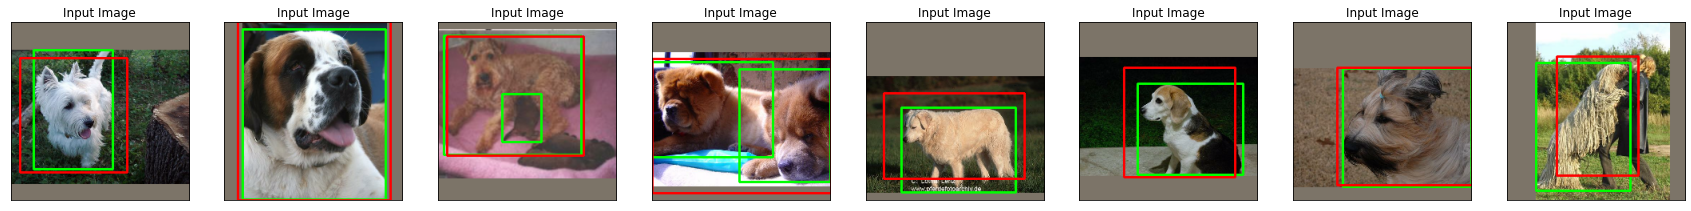

In [13]:
fig = plt.figure(figsize=(30, 10))
n=8
offset = 5
# Iterate through some images
for k in range(offset,n + offset, 1):
   curr_img = np.asarray(helper.unprocess_image(img_batch_test[k+n, :, :,:]))
   # draw a green rectangle to visualize the bounding rect
   curr_img=helper.image_with_gt_boxes(curr_img,batch_boxes_test[k+n],(0,255,0))

   # Plot image and show related indicator
   ax = fig.add_subplot(1, n, k - offset + 1, xticks=[], yticks=[])

   bounding_box = bounding_boxes[k+n] 
   curr_img = cv2.rectangle((curr_img), (bounding_box[0], bounding_box[1]), (bounding_box[2], bounding_box[3]), (255,0,0), 2)
   
   ax.imshow(curr_img)
   ax.set_title('Input Image')  

## Sheep dataset

In [19]:
# Importing the sheep dataset (using Pascal VOC dataset)
data_set = ["voc", 16] 


if data_set[0] == "voc":   
  src_train_dataset, info = tfds.load(data_set[0],split='train',with_info=True)
  src_val_dataset, info = tfds.load(data_set[0],split='validation',with_info=True)
  src_test_dataset, info = tfds.load(data_set[0],split='test',with_info=True)
  print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteJXWGB3/voc-test.tfrecord


  0%|          | 0/4952 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteJXWGB3/voc-train.tfrecord


  0%|          | 0/2501 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteJXWGB3/voc-validation.tfrecord


  0%|          | 0/2510 [00:00<?, ? examples/s]

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='voc',
    version=4.0.0,
    description='This dataset contains the data from the PASCAL Visual Object Classes Challenge
2007, a.k.a. VOC2007, corresponding to the Classification and Detection
competitions.
A total of 9963 images are included in this dataset, where each image
contains a set of objects, out of 20 different classes, making a total of
24640 annotated objects.
In the Classification competition, the goal is to predict the set of labels
contained in the image, while in the Detection competition the goal is to
predict the bounding box and label of each individual object.
annotations.',
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'labels': Sequence(Cla

In [21]:
train_dataset, test_dataset = helper.gen_datasets(data_set,src_train_dataset,src_test_dataset)

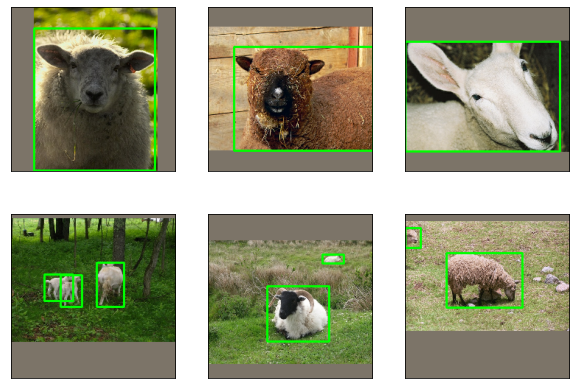

In [22]:
helper.display_dataset_img(train_dataset)

In [23]:
base_model = base_vgg_model()
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [25]:
n_img=100 # Default value.
img_batch,batch_boxes,op_features=gen_batch_features(train_dataset,n_img)
img_batch_test,batch_boxes_test,op_features_test=gen_batch_features(test_dataset,n_img)
print(np.shape(op_features))
print(np.shape(batch_boxes_test))
print(np.shape(img_batch_test))

(45, 14, 14, 512)
(45, None, 4)
(45, 224, 224, 3)


In [26]:
x_bar = calculate_mean_vector(op_features)

# Compute the principal component eigenvector
principal_component_vector = compute_principal_component_vector(op_features)

# Compute the indicator matrix in the same size as the original images
P1_upscaled = compute_upscaled_indicator(op_features_test, x_bar, principal_component_vector)

# Compute the bounding boxes of the largest connected areas of the binarized indicator matrix
bounding_boxes= DDT_bounding_boxes(P1_upscaled)

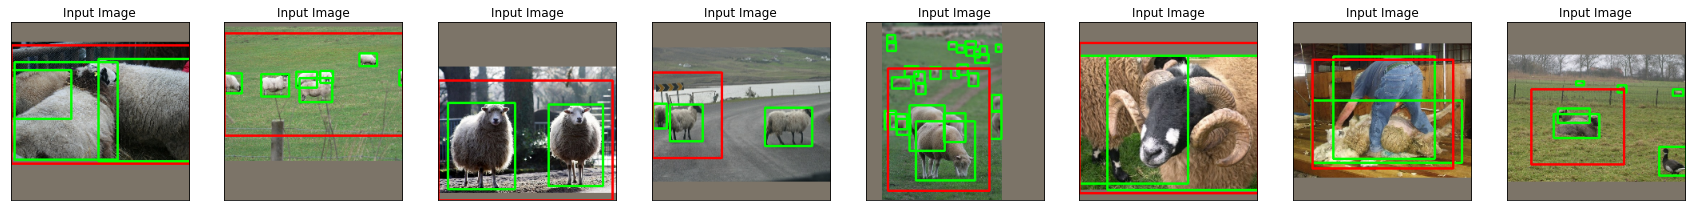

In [27]:
fig = plt.figure(figsize=(30, 10))
n=8
offset = 5
# Iterate through some images
for k in range(offset,n + offset, 1):
   curr_img = np.asarray(helper.unprocess_image(img_batch_test[k+n, :, :,:]))
   # draw a green rectangle to visualize the bounding rect
   curr_img=helper.image_with_gt_boxes(curr_img,batch_boxes_test[k+n],(0,255,0))

   # Plot image and show related indicator
   ax = fig.add_subplot(1, n, k - offset + 1, xticks=[], yticks=[])

   bounding_box = bounding_boxes[k+n] 
   curr_img = cv2.rectangle((curr_img), (bounding_box[0], bounding_box[1]), (bounding_box[2], bounding_box[3]), (255,0,0), 2)
   
   ax.imshow(curr_img)
   ax.set_title('Input Image') 

## Results of DDT on sheep dataset
Extremely poor results as there are multiple ground truth objects in the dataset and the DDT classifier just predicts one bounding box (given the largest eigenvector from PCA for all the dataset).  

Applying DDT+ will enable us to see if better results are possible

In [36]:
# Sepcifying the convolutions layers to use for the DDT+ algorithm 
layer_names = ['block5_conv3', 'block4_conv3']

# Create the pretrained VGG model
base_model_ddt_plus = base_vgg_model()

# Show summary of the VGG model
base_model_ddt_plus.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [39]:
def gen_batch_features_ddt_plus(train_dataset,n_img, i):

    cntr = 0
    for img, boxes, obj_cen, labels in train_dataset.take(n_img):
       img = img.to_tensor(shape=[batch_size, HW_trg, HW_trg, 3])
       # swap features depending on the final or penultimate layer
       A = base_model_ddt_plus(img)[i]

       # Append output features 
       if cntr >0:
          op_features = tf.concat([op_features,A],axis=0)
          img_batch = tf.concat([img_batch,img],axis=0)
          boxes_batch = tf.concat([boxes_batch,boxes],axis=0)
       else:   
          op_features= A
          img_batch = img
          boxes_batch = boxes
       cntr +=1  
     
    return img_batch,boxes_batch,op_features  

In [40]:
n_img=45 # Default value.
img_batch,batch_boxes,op_features_primary =gen_batch_features_ddt_plus(train_dataset,n_img, 0)
img_batch,batch_boxes,op_features_secondary =gen_batch_features_ddt_plus(train_dataset,n_img, 1)
img_batch_test,batch_boxes_test,op_features_test_primary =gen_batch_features_ddt_plus(test_dataset,n_img, 0)
img_batch_test,batch_boxes_test,op_features_test_secondary =gen_batch_features_ddt_plus(test_dataset,n_img, 1)
print(np.shape(op_features_primary))
print(np.shape(op_features_secondary))
print(np.shape(batch_boxes_test))
print(np.shape(img_batch_test))

(45, 14, 14, 512)
(45, 28, 28, 512)
(45, None, 4)
(45, 224, 224, 3)


In [41]:
# Primary
x_bar_primary = calculate_mean_vector(op_features_primary)
principal_component_vector_primary = compute_principal_component_vector(op_features_primary)
P1_upscaled_primary = compute_upscaled_indicator(op_features_test_primary, x_bar_primary, principal_component_vector_primary)

# Secondary
x_bar_secondary = calculate_mean_vector(op_features_secondary)
principal_component_vector_secondary = compute_principal_component_vector(op_features_secondary)
P1_upscaled_secondary = compute_upscaled_indicator(op_features_test_secondary, x_bar_secondary, principal_component_vector_secondary)

In [42]:
def determine_bounding_boxes_DDT_plus(P1_resized_A, P1_resized_B):
  """
  Function to return the bounding boxes predicted by the DDT+ algorithm

  Inputs: 
    P1_resized_A: The indicator matrix for the final layer
    P1_resized_B: The indicator matrix for the previous layer

  Returns: 
    bounding_boxes: The bounding boxes of the connected areas from the binary map intersections
    P1_binarized_A:   The indicator matrix of the last layer in a binary format 
    P1_binarized_B:   The indicator matrix of the previous layer in a binary format 
    P1_intersection:  The binarized intersections of the two indicator matrices
  """ 
  # Initialize the output variables  
  bounding_boxes = list()
  P1_binarized_A = list()
  P1_binarized_B = list()
  P1_intersection = list()

  for index, (p1_resized_A, p1_resized_B) in enumerate(zip(P1_resized_A, P1_resized_B)):
  	# Step 10: Collect the largest connected component Pˆ1_c of these positive regions of the resized P1 by Algo. 1;
    # Binarize the positive regions
    p1_binarized_A = tf.where(p1_resized_A > 0, 255, 0).numpy().astype(np.uint8)
    p1_binarized_B = tf.where(p1_resized_B > 0, 255, 0).numpy().astype(np.uint8)
    P1_binarized_A.append(p1_binarized_A)
    P1_binarized_B.append(p1_binarized_B)

    # Compute intersection of binary mappings
    p1_intersection = np.where((p1_binarized_A == p1_binarized_B) & (p1_binarized_A == 255), 255, 0).astype(np.uint8)
    P1_intersection.append(p1_intersection)

    # Determine bounding boxes for connected regions
    (_, _, stats, _) = cv2.connectedComponentsWithStats(p1_intersection, connectivity=8, ltype=cv2.CV_32S)
    # Select the largest non background region
    bounding_boxes_img = list()
    for (x, y, width, height) in stats[1:, :4]:
      # Add the coordinates of the bounding boxes
      bounding_boxes_img.append([x, y, x + width, y + height])

    # Add the images' bounding boxes to the overall list   
    bounding_boxes.append(bounding_boxes_img)

  # Step 13: return The minimum rectangle bounding boxes
  return bounding_boxes, P1_binarized_A, P1_binarized_B, P1_intersection

In [53]:
bounding_boxes_DDT_plus, P1_binarized_primary, P1_binarized_secondary, P1_intersection = determine_bounding_boxes_DDT_plus(P1_upscaled_primary, P1_upscaled_secondary)

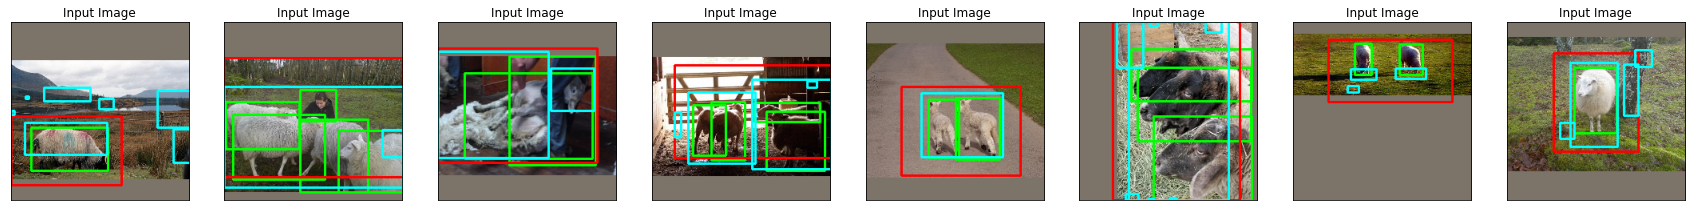

In [61]:
fig = plt.figure(figsize=(30, 10))
n=8
# Iterate through some images
for k in range(n):
   curr_img = np.asarray(helper.unprocess_image(img_batch_test[k, :, :,:]))
   # draw a green rectangle to visualize the bounding rect
   curr_img=helper.image_with_gt_boxes(curr_img,batch_boxes_test[k],(0,255,0))

   # Plot image and show related indicator
   ax = fig.add_subplot(1, n, k + 1, xticks=[], yticks=[])

   bounding_box = bounding_boxes[k] 
   curr_img = cv2.rectangle((curr_img), (bounding_box[0], bounding_box[1]), (bounding_box[2], bounding_box[3]), (255,0,0), 2)
   image_bounding_boxes_DDT_plus = bounding_boxes_DDT_plus[k] 
   for image_bounding_box in image_bounding_boxes_DDT_plus:
    curr_img = cv2.rectangle((curr_img), (image_bounding_box[0], image_bounding_box[1]), (image_bounding_box[2], image_bounding_box[3]), (0,255,255), 2)
   ax.imshow(curr_img)
   ax.set_title('Input Image') 

### Conclusion

This was a challenging etivity. The algorithm outlined in [Wei (2017)](https://arxiv.org/pdf/1707.06397.pdf) relied on relatively straight forward linear algebra such as PCA and calculating connected components, both of which we could utilise Python libraries for. However some of the OpenCV and Tensorflow functions to use were tricky as I was trying to use the NumPy counterpart functions in many cases. 


### Observations
The DDT algorithm was quite extensible to multiple objects by using it's final and penultimate layer together to produce binary maps, their intersections (via connected components) in order to create bounding boxes for the object detections.

Overall this etivity showed that the DDT classifier worked very well for one onject but was quite limited for too. However will the DDT+ was much better at working with multiple objects and instances of objects, it does produce a high number of false positives (I didn't come across any false negatives), whereas the DDT produces lots of false negatives for multiclass.

Overall the DDT+ is a definite improvement on the DDT.


### Classmate forum help
Shout out to Andy Lynch in the course who showed me the useful resize, interpolate function in `tf` and Ken who's function on creating the DDT bounding boxes I used and really liked where in leaned upon using OpenCV's ConnectedComponentswithStats function.

